In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


train_data = datasets.FashionMNIST('./data', train=True, download=True,
                            transform=transforms.ToTensor())


# pin memory provides improved transfer speed
kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {}

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=128, shuffle=True, **kwargs)



class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc21 = nn.Linear(512, 2)  # fc21 for mean of Z
        self.fc22 = nn.Linear(512, 2)  # fc22 for log variance of Z
        self.fc3 = nn.Linear(2, 512)
        self.fc4 = nn.Linear(512, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        mu = self.fc21(h1)
        logvar = self.fc22(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.rand_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        # x: [batch size, 1, 28,28] -> x: [batch size, 784]
        x = x.view(-1, 784)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [3]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr= 1e-3)


def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = 0.5 * torch.sum(mu.pow(2) + logvar.exp() - logvar - 1)

    return BCE + KLD

In [4]:
def train_loss(epoch):
    model.train()
    total_train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()  
        data = data.to(device) 
        
        recon_data, mu, logvar = model(data)
        
        loss = loss_function(recon_data, data, mu, logvar)
        
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()

    avg_loss = total_train_loss / len(train_loader.dataset)

    return avg_loss


In [5]:
import matplotlib.pyplot as plt

# List to store training losses for each epoch
train_losses = []
EPOCHS = 30

# Training loop
for epoch in range(1, EPOCHS + 1):
    avg_train_loss = train_loss(epoch)
    train_losses.append(avg_train_loss)  # Store the loss
    print(f'Epoch {epoch}, Average Train Loss: {avg_train_loss:.4f}')


Epoch 1, Average Train Loss: 285.1947
Epoch 2, Average Train Loss: 268.5520
Epoch 3, Average Train Loss: 266.4174
Epoch 4, Average Train Loss: 265.0472
Epoch 5, Average Train Loss: 264.0077
Epoch 6, Average Train Loss: 263.2556
Epoch 7, Average Train Loss: 262.4907
Epoch 8, Average Train Loss: 261.8064
Epoch 9, Average Train Loss: 261.3472
Epoch 10, Average Train Loss: 260.7908
Epoch 11, Average Train Loss: 260.3715
Epoch 12, Average Train Loss: 259.9683
Epoch 13, Average Train Loss: 259.6038
Epoch 14, Average Train Loss: 259.3431
Epoch 15, Average Train Loss: 259.0739
Epoch 16, Average Train Loss: 258.8241
Epoch 17, Average Train Loss: 258.5394
Epoch 18, Average Train Loss: 258.3025
Epoch 19, Average Train Loss: 258.1151
Epoch 20, Average Train Loss: 257.8610
Epoch 21, Average Train Loss: 257.7883
Epoch 22, Average Train Loss: 257.5526
Epoch 23, Average Train Loss: 257.5043
Epoch 24, Average Train Loss: 257.2354
Epoch 25, Average Train Loss: 257.1029
Epoch 26, Average Train Loss: 257.

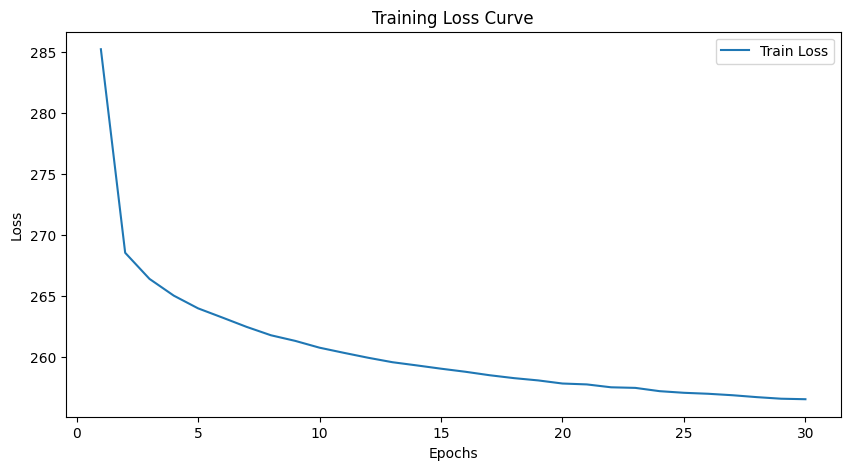

In [6]:
def plot_loss_curve(train_losses):
    # Create the plot
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    
    # Add labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    
    # Add a legend
    plt.legend()
    
    # Display the plot
    plt.show()

# After training, call this function to plot the loss curve
plot_loss_curve(train_losses)


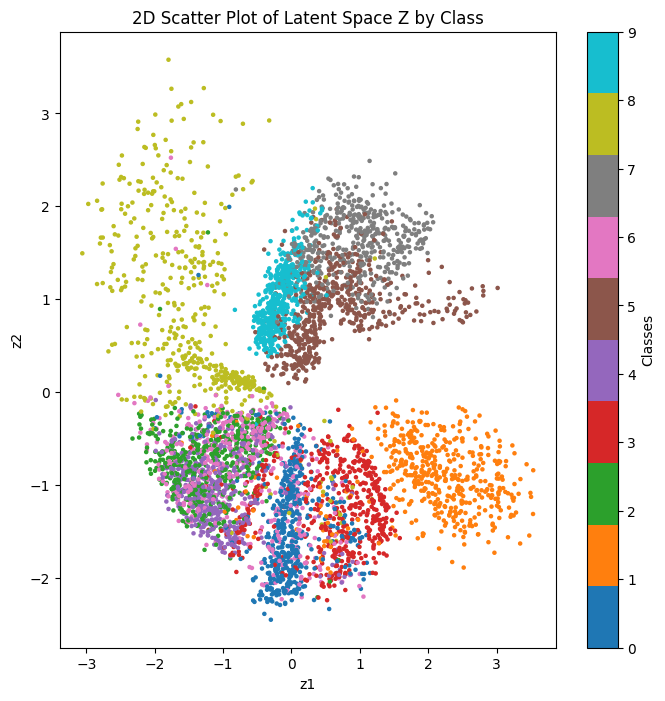

In [7]:
def plot_latent_space(model, data_loader, num_samples=5000):
    model.eval()
    z_values = []
    labels_list = []
    
    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(data_loader):
            data = data.view(-1, 784).to(device) 
            mu, _ = model.encode(data) 
            z_values.append(mu.cpu().numpy())  
            labels_list.append(labels.cpu().numpy()) 
            
            if len(z_values) * data.shape[0] >= num_samples:
                break

    z_values = np.concatenate(z_values)[:num_samples]
    labels_list = np.concatenate(labels_list)[:num_samples]

    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(z_values[:, 0], z_values[:, 1], c=labels_list, cmap='tab10', s=5)

    # Add color bar for the classes
    plt.colorbar(scatter, ticks=range(10), label='Classes')
    
    # Add labels and title
    plt.title("2D Scatter Plot of Latent Space Z by Class")
    plt.xlabel("z1")
    plt.ylabel("z2")

    # Show plot
    plt.show()

# After training, call the function:
plot_latent_space(model, train_loader)


/tmp/ipykernel_2220566/1662419510.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  sample = torch.tensor([z]).float().to(device)


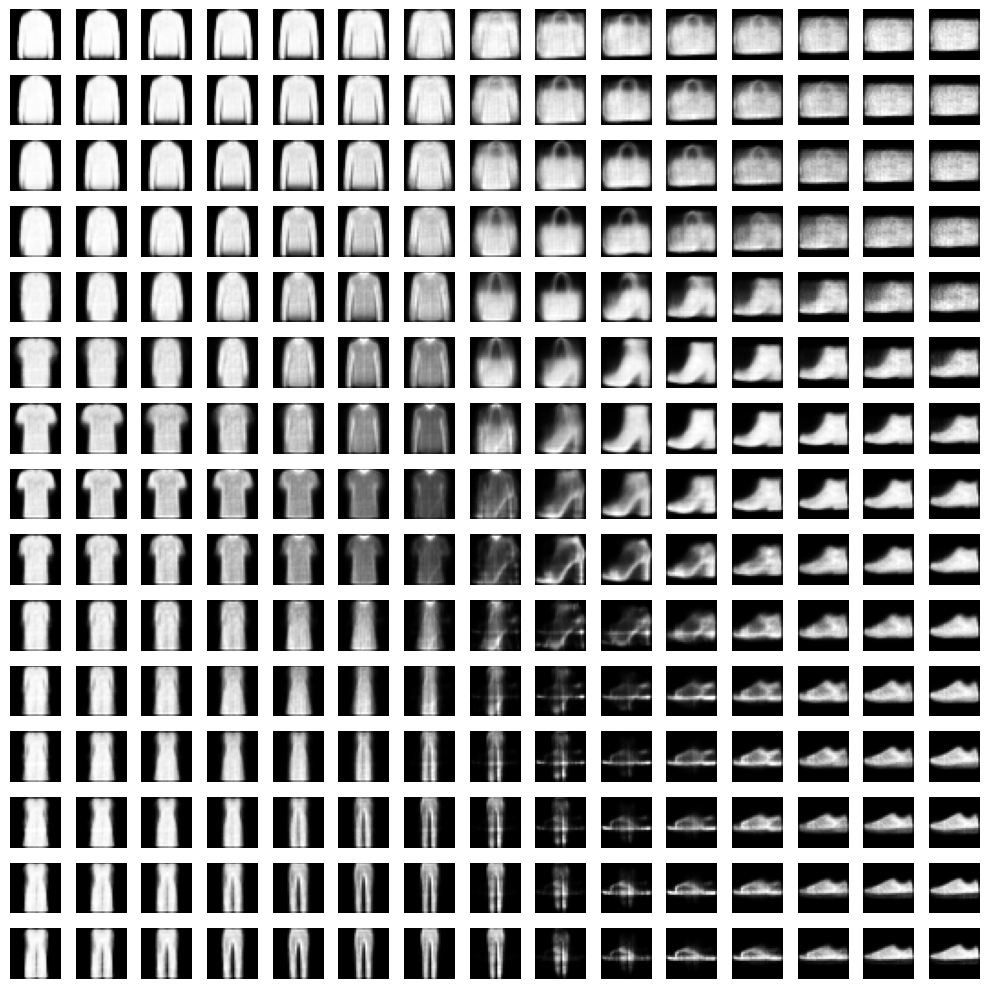

In [8]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def generate_images_for_grid():
    # Create a grid of 15x15 z-values ranging from -2 to 2 in both dimensions
    grid_size = 15
    z_range = np.linspace(-2, 2, grid_size)
    z_values = np.array([[x, y] for x in z_range for y in z_range])

    # Ensure model is in evaluation mode and no gradients are computed
    with torch.no_grad():
        plt.figure(figsize=(10, 10))
        
        # Iterate through the grid and generate images
        for i, z in enumerate(z_values):
            sample = torch.tensor([z]).float().to(device)
            generated_image = model.decode(sample).cpu().view(28, 28).numpy()
            
            # Plot each image in the 15x15 grid
            plt.subplot(grid_size, grid_size, i + 1)
            plt.imshow(generated_image, cmap='gray')
            plt.axis('off')  # Turn off axis labels for clarity
    
    plt.tight_layout()
    plt.show()

# Call the function:
generate_images_for_grid()

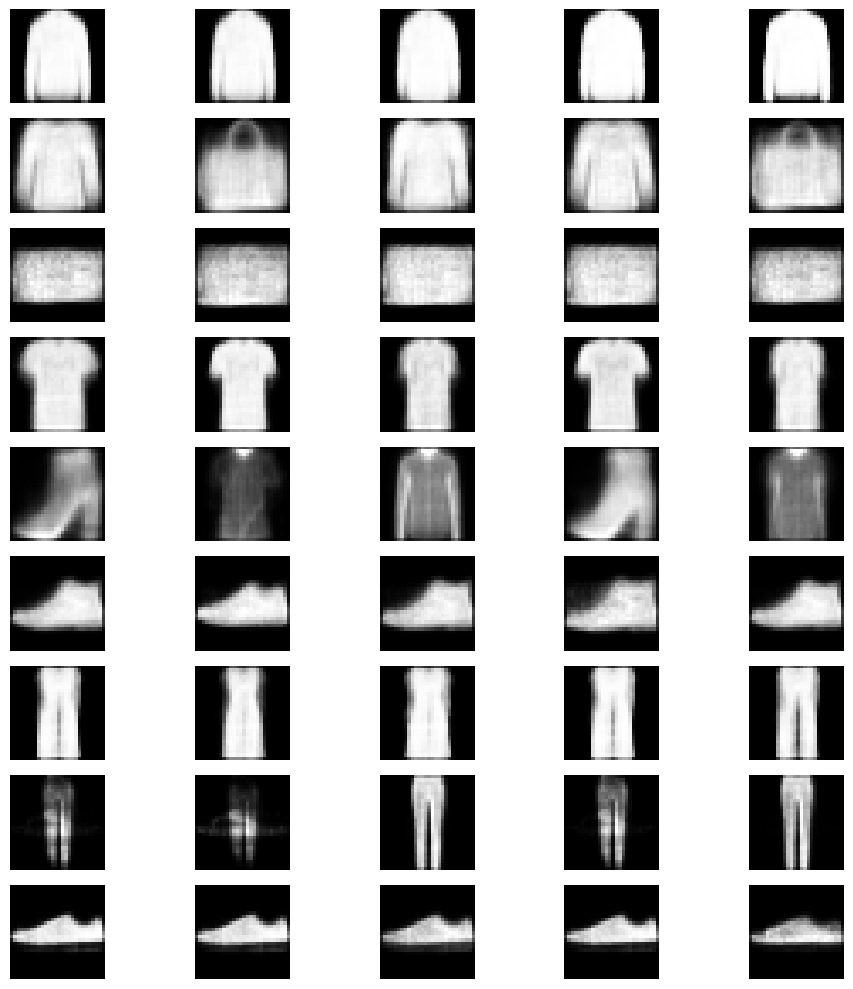

In [9]:
def generate_images_for_categories():
    # List of base z-values corresponding to each category
    category_z_values = [[-2, -2], [-2, 0], [-2, 2], [0, -2], [0, 0], [0, 2], [2, -2], [2, 0], [2, 2]]

    num_samples = 5

    variation_range = 0.5

    with torch.no_grad():
        plt.figure(figsize=(10, 10))
        
        for row, base_z in enumerate(category_z_values):
            base_z = np.array(base_z)

            for col in range(num_samples):
                variation = np.random.uniform(-variation_range, variation_range, size=2)
                z = base_z + variation
                sample = torch.tensor([z]).float().to(device)

                generated_image = model.decode(sample).cpu().view(28, 28).numpy()
                plt.subplot(len(category_z_values), num_samples, row * num_samples + col + 1)
                plt.imshow(generated_image, cmap='gray')
                plt.axis('off') 
    plt.tight_layout()
    plt.show()

generate_images_for_categories()
